### Import Dependencies

In [1]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

### Device agnostic

In [2]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

### ReplayMemory

In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### Network Architecture

In [4]:
class DQN(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )

        # For the wrapper with image_size=(84, 84) and k=4 frames:
        # After conv layers: 84 -> 20 -> 9 -> 7, so 64 * 7 * 7 = 3136
        self.fc = nn.Sequential(
            nn.Linear(3136, 256), 
            nn.ReLU(), 
            nn.Linear(256, out_channels)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Input should be [batch, channels, height, width]
        x = self.conv(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

### Setup environment

In [5]:
import dino

# Create environment with training mode for better learning
env = gym.make('Dino-v0', render_mode='rgb_array', game_mode='train', train_frame_limit=5000)
# Use the wrapper from the reference implementation for frame stacking
env = dino.Wrapper(env, k=4, image_size=(84, 84))

In [6]:
test_env = gym.make('Dino-v0', render_mode='rgb_array', game_mode='train')
test_env_wrapper = dino.Wrapper(test_env, k=4, image_size=(84, 84))

In [7]:
torch.manual_seed(0)
test_env.reset()
test_env_wrapper.reset()
for _ in range(55):
    ts, *_ = test_env.step(0)
    sss, *_ = test_env_wrapper.step(0)
ts.shape, sss.shape

((512, 1024, 3), (4, 84, 84))

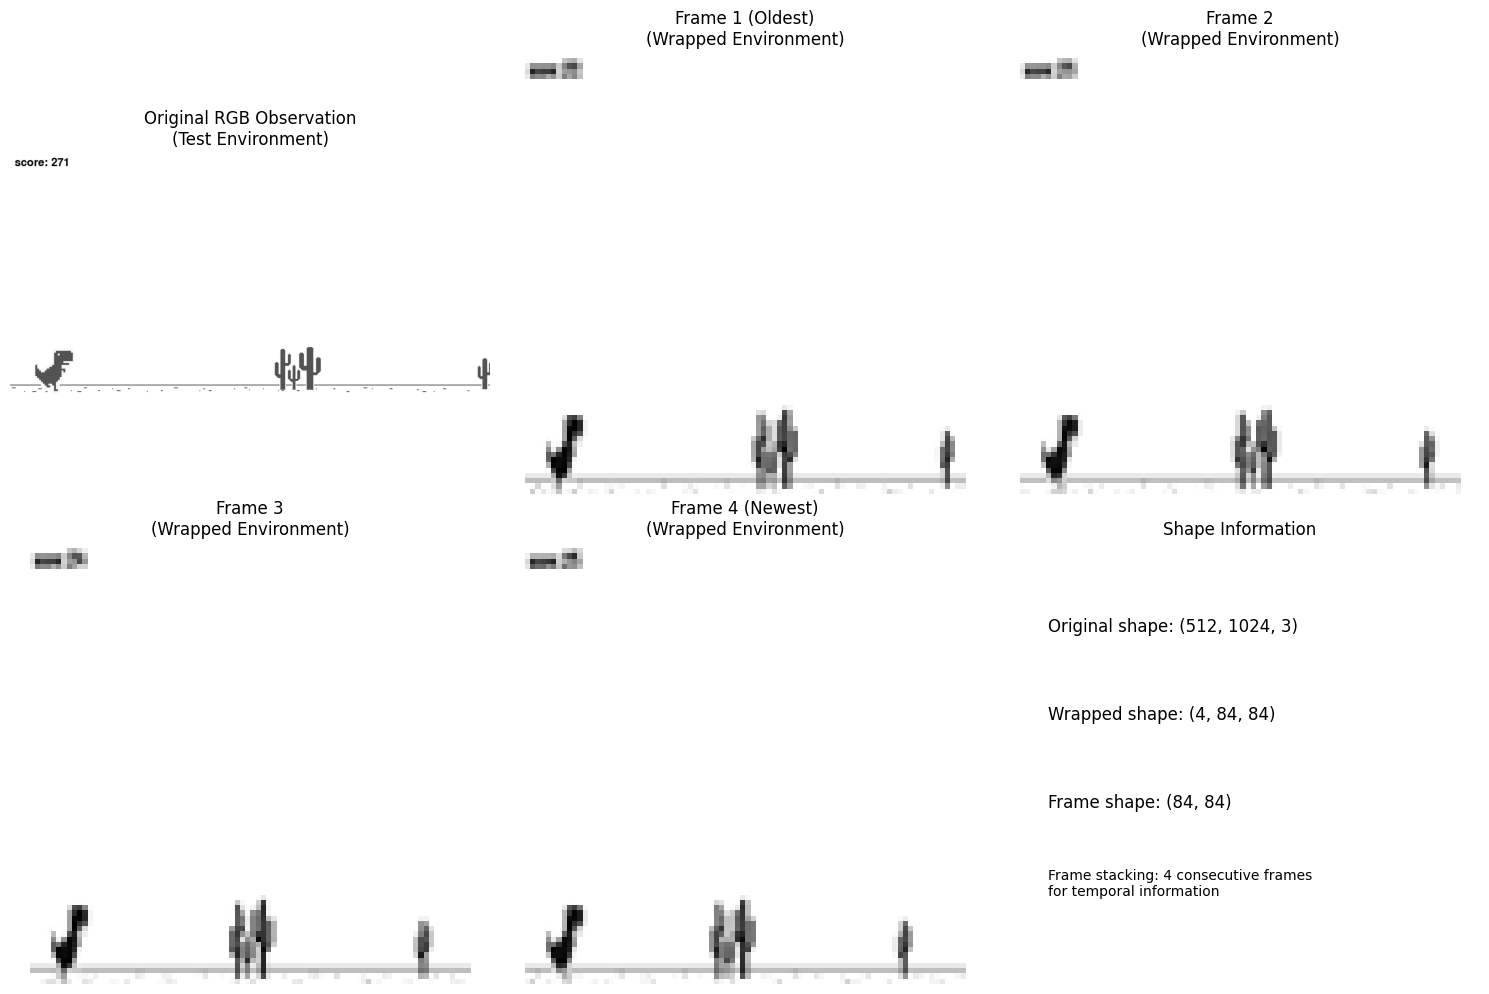

In [8]:
plt.figure(figsize=(15, 10))

# Original RGB observation from test environment
plt.subplot(2, 3, 1)
plt.title("Original RGB Observation\n(Test Environment)")
plt.imshow(ts)
plt.axis('off')

# Show all 4 stacked frames from wrapped environment
plt.subplot(2, 3, 2)
plt.title("Frame 1 (Oldest)\n(Wrapped Environment)")
plt.imshow(sss[0], cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.title("Frame 2\n(Wrapped Environment)")
plt.imshow(sss[1], cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.title("Frame 3\n(Wrapped Environment)")
plt.imshow(sss[2], cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.title("Frame 4 (Newest)\n(Wrapped Environment)")
plt.imshow(sss[3], cmap='gray')
plt.axis('off')

# Show the shape information
plt.subplot(2, 3, 6)
plt.text(0.1, 0.8, f"Original shape: {ts.shape}", fontsize=12, transform=plt.gca().transAxes)
plt.text(0.1, 0.6, f"Wrapped shape: {sss.shape}", fontsize=12, transform=plt.gca().transAxes)
plt.text(0.1, 0.4, f"Frame shape: {sss[0].shape}", fontsize=12, transform=plt.gca().transAxes)
plt.text(0.1, 0.2, "Frame stacking: 4 consecutive frames\nfor temporal information", fontsize=10, transform=plt.gca().transAxes)
plt.title("Shape Information")
plt.axis('off')

plt.tight_layout()
plt.show()

### Data Preprocessing

In [ ]:
def preprocess_observation(obs):
    # Convert to tensor if it's numpy array
    if isinstance(obs, np.ndarray):
        obs = torch.tensor(obs, dtype=torch.float32, device=device)
    # Normalize to [0, 1] if not already normalized
    if obs.max() > 1.0:
        obs = obs / 255.0
    return obs

# Test the preprocessing function with the wrapped environment
test_obs, _ = env.reset()
print(f"Wrapped observation shape: {test_obs.shape}")
processed_obs = preprocess_observation(test_obs)
print(f"Processed observation shape: {processed_obs.shape}")
print(f"Processed observation range: [{processed_obs.min():.3f}, {processed_obs.max():.3f}]")

Wrapped observation shape: (4, 84, 84)
Processed observation shape: torch.Size([4, 84, 84])
Processed observation range: [0.290, 1.000]


#### Setting up hyperparameters, networks

In [ ]:
BATCH_SIZE = 64  # Smaller batch size as in reference
GAMMA = 0.99
EPS_START = 1.0  # Start with full exploration
EPS_END = 0.01
EPS_DECAY = 10000  # Longer decay period
TAU = 0.005  # Keep target network update rate
LR = 1e-4  # Lower learning rate as in reference

# Experience replay settings
REPLAY_SIZE = 10000
LEARNING_START = 10000  # Start learning after collecting enough experiences
TARGET_UPDATE_FREQ = 1000  # Update target network every 1000 steps
OPTIMIZE_FREQ = 1  # Optimize every step

# Get environment information
n_actions = env.action_space.n
print(f"Number of actions: {n_actions}")

# Get observation space - should be (k, height, width) after wrapper
state, info = env.reset()
print(f"Wrapped state shape: {state.shape}")
n_observations = state.shape[0]  # Number of stacked frames (k=4)
print(f"Number of observation channels: {n_observations}")

# Initialize networks with correct architecture
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

# Optimizer
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

# Experience replay memory
memory = ReplayMemory(REPLAY_SIZE)

# Training state
steps_done = 0

print(f"✅ Networks recreated with correct architecture!")
print(f"   Policy network: {sum(p.numel() for p in policy_net.parameters())} parameters")
print(f"   Target network: {sum(p.numel() for p in target_net.parameters())} parameters")

def select_action(state):   # Using epsilon-greedy policy
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    
    if sample > eps_threshold:
        with torch.no_grad():
            # Convert state to tensor if needed and add batch dimension
            if isinstance(state, np.ndarray):
                state = torch.tensor(state, dtype=torch.float32, device=device)
            if len(state.shape) == 3:  # [C, H, W] -> [1, C, H, W]
                state = state.unsqueeze(0)
            
            # Get Q-values and select best action
            q_values = policy_net(state)
            action = q_values.max(1)[1]
            return action
    else:
        return torch.tensor([env.action_space.sample()], device=device, dtype=torch.long)

episode_durations = []

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

Number of actions: 3
Wrapped state shape: (4, 84, 84)
Number of observation channels: 4
✅ Networks recreated with correct architecture!
   Policy network: 881827 parameters
   Target network: 881827 parameters


#### Optimize the model after OPTIMIZE_FREQ steps

In [11]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
        
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    
    # Process states - convert to tensors if needed
    state_batch = []
    for state in batch.state:
        if isinstance(state, np.ndarray):
            state = torch.tensor(state, dtype=torch.float32, device=device)
        state_batch.append(state)
    state_batch = torch.stack(state_batch)
    
    # Process actions
    action_batch = torch.cat(batch.action)
    if len(action_batch.shape) == 1:
        action_batch = action_batch.unsqueeze(1)
    
    # Process rewards
    reward_batch = torch.cat(batch.reward)
    
    # Process next states (only non-final ones)
    non_final_next_states = []
    for state in batch.next_state:
        if state is not None:
            if isinstance(state, np.ndarray):
                state = torch.tensor(state, dtype=torch.float32, device=device)
            non_final_next_states.append(state)
    
    if len(non_final_next_states) > 0:
        non_final_next_states = torch.stack(non_final_next_states)
    else:
        non_final_next_states = torch.empty(0, n_observations, 84, 84, device=device)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        if len(non_final_next_states) > 0:
            next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    
    # Compute the expected Q values using Bellman equation
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss (SmoothL1Loss)
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Gradient clipping to prevent exploding gradients
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [12]:
# Additional utility functions for training monitoring
import os
from PIL import Image

def get_epsilon():
    """Get current epsilon value for monitoring exploration"""
    return EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)

def print_training_stats():
    """Print current training statistics"""
    if len(episode_durations) > 0:
        avg_duration = np.mean(episode_durations[-10:])  # Last 10 episodes
        current_eps = get_epsilon()
        print(f"Steps: {steps_done}, Epsilon: {current_eps:.3f}, Avg Duration (last 10): {avg_duration:.1f}")

def save_obs_result(episode_i: int, obs_arr: list[np.ndarray]):
        frames = [Image.fromarray(obs, "RGB") for obs in obs_arr]
        file_path = os.path.join("models", f"episode-{episode_i}.gif")

        frames[0].save(
            file_path,
            save_all=True,
            append_images=frames[1:],
            optimize=True,
            duration=100,
            loop=0,
        )

# This cell is ready for additional monitoring utilities as needed
print("Training utilities loaded successfully!")

Training utilities loaded successfully!


Starting training for 2000 episodes...
Device: cuda
Learning will start after 10000 steps
Episode 0, duration: 1250, total reward: -23.00, steps: 1250
Episode 100, duration: 1250, total reward: 39.00, steps: 126250
Episode 200, duration: 1250, total reward: 16.00, steps: 251250
Model saved at episode 200
Episode 300, duration: 1250, total reward: 8.00, steps: 376250
Episode 400, duration: 1250, total reward: 49.00, steps: 501250
Model saved at episode 400
Episode 500, duration: 1250, total reward: -19.00, steps: 626250
Episode 600, duration: 1250, total reward: 12.00, steps: 751250
Model saved at episode 600
Episode 700, duration: 1250, total reward: 78.00, steps: 876250
Episode 800, duration: 1250, total reward: 26.00, steps: 1001250
Model saved at episode 800
Episode 900, duration: 1250, total reward: 66.00, steps: 1126250
Episode 1000, duration: 1250, total reward: 29.00, steps: 1251250
Model saved at episode 1000
Episode 1100, duration: 1250, total reward: 16.00, steps: 1376250
Epi

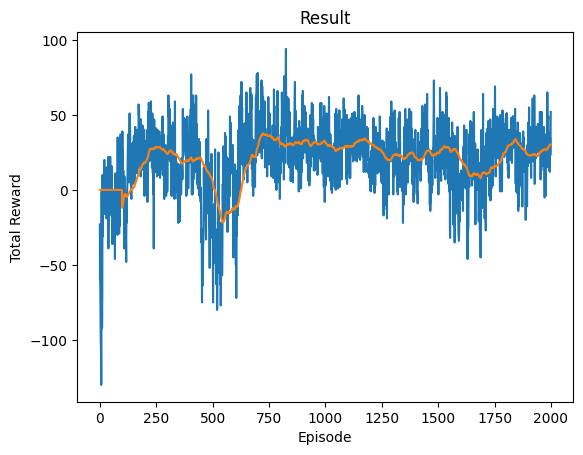

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Final model saved as 'models/dino_final.pth'
CPU times: user 15h 19min 19s, sys: 1min 23s, total: 15h 20min 43s
Wall time: 15h 23min 19s


In [ ]:
%%time

# Training configuration

if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 2000
else:
    num_episodes = 100

print(f"Starting training for {num_episodes} episodes...")
print(f"Device: {device}")
print(f"Learning will start after {LEARNING_START} steps")

n_steps = 0  # Global step counter

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = preprocess_observation(state)
    total_reward = 0.0
    
    for t in count():
        n_steps += 1
        
        # Select and perform an action
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(dino.Action(action.item()))
        
        total_reward += reward
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        # Start learning after collecting enough experiences
        if n_steps > LEARNING_START:
            # Perform one step of the optimization (on the policy network)
            if n_steps % OPTIMIZE_FREQ == 0:
                optimize_model()

            # Update the target network, copying all weights and biases in DQN
            if n_steps % TARGET_UPDATE_FREQ == 0:
                target_net.load_state_dict(policy_net.state_dict())
                
                # target_net_state_dict = target_net.state_dict()
                # policy_net_state_dict = policy_net.state_dict()
                # for key in policy_net_state_dict:
                #     target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
                # target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(total_reward)
            if i_episode % 100 == 0:
                print(f"Episode {i_episode}, duration: {t + 1}, total reward: {total_reward:.2f}, steps: {n_steps}")
            # plot_durations()
            break
        else:
            next_state = preprocess_observation(observation)
            # Move to the next state
            state = next_state
            # Store the transition in memory
            memory.push(state, action, next_state, reward)

    # Save model periodically
    if i_episode % 200 == 0 and i_episode > 0:
        torch.save(policy_net.state_dict(), f"models/dino_episode_{i_episode}.pth")
        # save_obs_result(i_episode, env.frames)
        print(f"Model saved at episode {i_episode}")
env.close()

print('Training Complete!')
plot_durations(show_result=True)
plt.ioff()
plt.show()

# Save the final trained model
torch.save(policy_net.state_dict(), "models/dino_final.pth")
print("Final model saved as 'models/dino_final.pth'")

In [14]:
# Model management utilities
def save_model(model, filename):
    """Save model with timestamp"""
    torch.save(model.state_dict(), filename)
    print(f"Model saved as: {filename}")

def load_model(filename, n_observations, n_actions):
    """Load model from file"""
    model = DQN(n_observations, n_actions).to(device)
    model.load_state_dict(torch.load(filename, map_location=device))
    model.eval()
    return model

# Example usage:
# save_model(policy_net, "my_model.pth")
# loaded_model = load_model("my_model.pth", n_observations, n_actions)
print("Model management utilities ready!")

Model management utilities ready!


In [15]:
# Greedy action selection for evaluation (no exploration)
def select_action_greedy(state, model):
    """Select action greedily without exploration for evaluation"""
    with torch.no_grad():
        # Convert to tensor if needed
        if isinstance(state, np.ndarray):
            state = torch.tensor(state, dtype=torch.float32, device=device)
        
        # Ensure state has correct batch dimension
        if len(state.shape) == 3:  # [C, H, W] -> [1, C, H, W]
            state = state.unsqueeze(0)
        
        # Get Q-values and select the action with highest Q-value
        q_values = model(state)
        action = q_values.max(dim=1)[1]
        return action

# Evaluation and performance metrics
def evaluate_agent(model, num_episodes=10, max_steps=1000):
    """Evaluate agent performance over multiple episodes"""
    print(f"📊 Evaluating agent over {num_episodes} episodes...")
    
    episode_rewards = []
    episode_lengths = []
    
    for episode in range(num_episodes):
        state, info = env.reset()
        state = preprocess_observation(state)
        total_reward = 0
        steps = 0
        
        for step in range(max_steps):
            # Select action greedily (no exploration)
            action = select_action_greedy(state, model)
            
            # Take action
            observation, reward, terminated, truncated, _ = env.step(dino.Action(action.item()))
            total_reward += reward
            steps += 1
            
            # Update state
            if not (terminated or truncated):
                state = preprocess_observation(observation)
            else:
                break
        
        episode_rewards.append(total_reward)
        episode_lengths.append(steps)
        
        if (episode + 1) % 5 == 0:
            print(f"  Episode {episode + 1}/{num_episodes} completed - Length: {steps}, Reward: {total_reward:.2f}")
    
    # Calculate statistics
    avg_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    avg_length = np.mean(episode_lengths)
    max_length = np.max(episode_lengths)
    min_length = np.min(episode_lengths)
    
    print("\n🏆 Performance Summary:")
    print(f"   📈 Average Reward: {avg_reward:.2f} ± {std_reward:.2f}")
    print(f"   ⏱️  Average Survival: {avg_length:.1f} steps")
    print(f"   🥇 Best Performance: {max_length} steps")
    print(f"   📉 Worst Performance: {min_length} steps")
    print(f"   💯 Success Rate: {(np.array(episode_lengths) > 100).mean()*100:.1f}% (>100 steps)")
    
    # Plot performance distribution
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.hist(episode_rewards, bins=10, alpha=0.7, color='green', edgecolor='black')
    plt.title('Reward Distribution')
    plt.xlabel('Total Reward')
    plt.ylabel('Frequency')
    plt.axvline(avg_reward, color='red', linestyle='--', label=f'Mean: {avg_reward:.2f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 2)
    plt.hist(episode_lengths, bins=10, alpha=0.7, color='blue', edgecolor='black')
    plt.title('Survival Time Distribution')
    plt.xlabel('Steps Survived')
    plt.ylabel('Frequency')
    plt.axvline(avg_length, color='red', linestyle='--', label=f'Mean: {avg_length:.1f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 3)
    plt.plot(range(1, num_episodes + 1), episode_lengths, 'o-', alpha=0.7)
    plt.title('Performance Over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Steps Survived')
    plt.axhline(avg_length, color='red', linestyle='--', label=f'Average: {avg_length:.1f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'rewards': episode_rewards,
        'lengths': episode_lengths,
        'avg_reward': avg_reward,
        'avg_length': avg_length,
        'max_length': max_length
    }

# Load and evaluate the trained agent
def load_and_evaluate(model_path, num_episodes=20):
    print(f"🧪 Loading and evaluating trained Chrome Dino agent from {model_path}...")
    
    # Load the trained model
    trained_model = DQN(n_observations, n_actions).to(device)
    trained_model.load_state_dict(torch.load(model_path, map_location=device))
    trained_model.eval()  # Set to evaluation mode
    
    performance = evaluate_agent(trained_model, num_episodes=num_episodes)
    return performance

# You can evaluate the model after training with:
# performance = load_and_evaluate("dino_final_model.pth")

🧪 Loading and evaluating trained Chrome Dino agent from dino_final_model.pth...
📊 Evaluating agent over 20 episodes...
  Episode 5/20 completed - Length: 1000, Reward: 98.00
  Episode 10/20 completed - Length: 1000, Reward: 83.00
  Episode 15/20 completed - Length: 1000, Reward: 73.00
  Episode 20/20 completed - Length: 1000, Reward: 88.00

🏆 Performance Summary:
   📈 Average Reward: 89.05 ± 9.22
   ⏱️  Average Survival: 1000.0 steps
   🥇 Best Performance: 1000 steps
   📉 Worst Performance: 1000 steps
   💯 Success Rate: 100.0% (>100 steps)


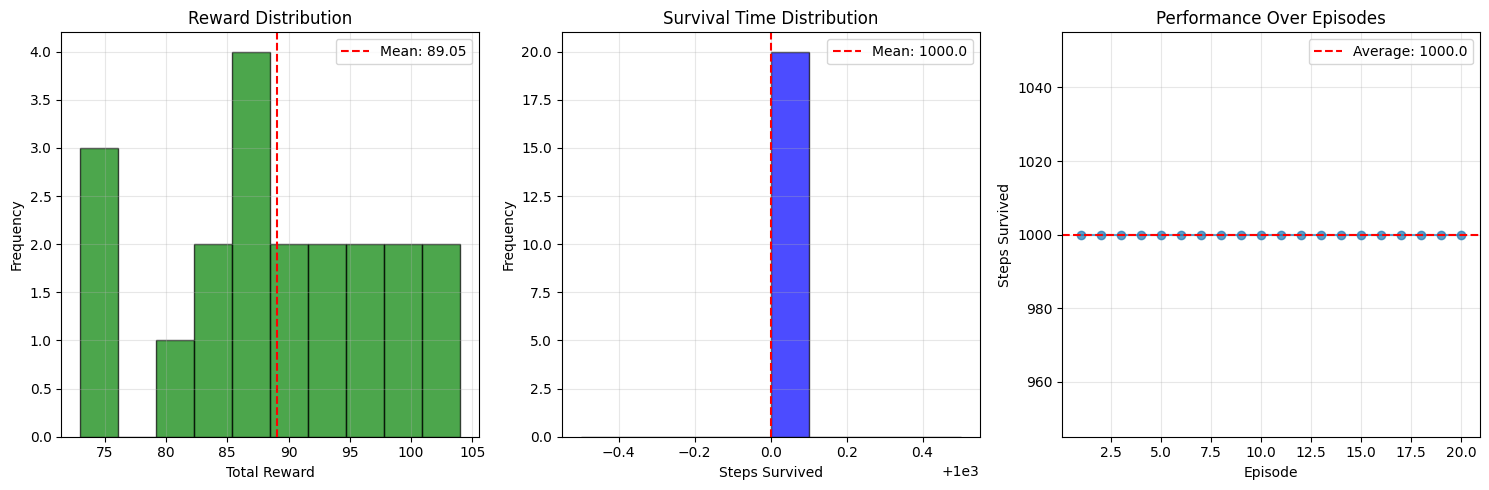

In [16]:
performance = load_and_evaluate("dino_final_model.pth")

# 🔍 Deep Q-Network (DQN) Algorithm Explained

## Overview
The Deep Q-Network (DQN) algorithm combines Q-learning with deep neural networks to learn optimal policies in environments with high-dimensional state spaces (like images). Let's break down each step and examine the tensor sizes throughout the process.

## 🏗️ Architecture Components

### 1. **Neural Network Architecture**
```
Input: RGB Image (512, 1024, 3) → Preprocessing → Grayscale (4, 84, 84)

CNN Architecture:
- Conv2d(4, 32, kernel_size=8, stride=4): (4, 84, 84) → (32, 20, 20)
- Conv2d(32, 64, kernel_size=4, stride=2): (32, 20, 20) → (64, 9, 9) 
- Conv2d(64, 64, kernel_size=3, stride=1): (64, 9, 9) → (64, 7, 7)
- Flatten: (64, 7, 7) → (3136,)
- Linear(3136, 256): (3136,) → (256,)
- Linear(256, 3): (256,) → (3,)  # 3 actions: STAND, JUMP, DUCK
```

### 2. **Key Hyperparameters**
- **BATCH_SIZE = 64**: Number of experiences sampled from replay buffer
- **GAMMA = 0.99**: Discount factor for future rewards
- **EPS_START = 0.9**: Initial exploration probability
- **EPS_END = 0.01**: Final exploration probability
- **TAU = 0.005**: Soft update rate for target network

## 🔄 Training Loop: Step-by-Step Breakdown

### **Step 1: Environment Interaction**
```python
state, info = env.reset()  # Initial state
state = preprocess_observation(state)  # (512, 1024, 3) → (4, 84, 84)
```
- **Input**: Raw RGB image from Chrome Dino game
- **Output**: Preprocessed grayscale tensor `(4, 84, 84)`

### **Step 2: Action Selection (ε-greedy)**
```python
action = select_action(state)  # Uses ε-greedy policy
```
- **Input**: State tensor `(4, 84, 84)`
- **Process**: 
  - Forward pass through policy network: `(4, 84, 84)` → `(3,)` Q-values
  - With probability ε: select random action
  - With probability (1-ε): select argmax(Q-values)
- **Output**: Action tensor `(1,)` with value in {0, 1, 2}

### **Step 3: Environment Step**
```python
observation, reward, terminated, truncated, _ = env.step(action.item())
```
- **Input**: Action integer (0=STAND, 1=JUMP, 2=DUCK)
- **Output**: 
  - New observation: `(512, 1024, 3)`
  - Reward: scalar (typically 0.0, 1.0 for passing obstacle, -1.0 for collision)
  - Terminal flags: boolean

### **Step 4: Experience Storage**
```python
memory.push(state, action, next_state, reward)
```
- **Stored transition**: `(state, action, next_state, reward)`
- **Sizes**: `((4,84,84), (1,), (4,84,84), (1,))`
- **Memory capacity**: 10,000 transitions

## 🎯 Optimization Step: The Heart of DQN

### **Step 5: Batch Sampling & Processing**
```python
transitions = memory.sample(BATCH_SIZE)  # Sample 64 random experiences
batch = Transition(*zip(*transitions))   # Transpose to batch format
```

**Batch Components After Processing:**
- **state_batch**: `(64, 4, 84, 84)` - 64 current states
- **action_batch**: `(64, 1)` - 64 actions taken  
- **next_state_batch**: `(N, 4, 84, 84)` - N non-terminal next states (N ≤ 64)
- **reward_batch**: `(64,)` - 64 immediate rewards
- **non_final_mask**: `(64,)` - Boolean mask for non-terminal states

### **Step 6: Current Q-Value Computation**
```python
state_action_values = policy_net(state_batch).gather(1, action_batch)
```
- **policy_net(state_batch)**: `(64, 4, 84, 84)` → `(64, 3)` Q-values for all actions
- **gather(1, action_batch)**: `(64, 3)` + `(64, 1)` → `(64, 1)` selected Q-values
- **Output**: Q(s,a) for the actions actually taken

### **Step 7: Target Q-Value Computation**
```python
next_state_values = torch.zeros(BATCH_SIZE, device=device)  # (64,)
next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
expected_state_action_values = (next_state_values * GAMMA) + reward_batch
```
- **target_net(non_final_next_states)**: `(N, 4, 84, 84)` → `(N, 3)` 
- **.max(1).values**: `(N, 3)` → `(N,)` - Best Q-values for next states
- **Expected Q-values**: `(64,)` using Bellman equation: Q_target = r + γ * max_a'(Q(s',a'))

### **Step 8: Loss Computation & Backpropagation**
```python
criterion = nn.SmoothL1Loss()
loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
```
- **state_action_values**: `(64, 1)` - Current Q-values Q(s,a)
- **expected_state_action_values**: `(64, 1)` - Target Q-values 
- **loss**: Scalar - Huber loss between predicted and target Q-values
- **SmoothL1Loss**: More robust than MSE, less sensitive to outliers

### **Step 9: Gradient Descent Update**
```python
optimizer.zero_grad()           # Clear previous gradients
loss.backward()                 # Compute gradients via backpropagation
torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)  # Gradient clipping
optimizer.step()                # Update network weights
```
- **Gradient clipping**: Prevents exploding gradients by limiting magnitude to 100
- **AdamW optimizer**: Adaptive learning rate with weight decay

### **Step 10: Target Network Soft Update**
```python
target_net_state_dict = target_net.state_dict()
policy_net_state_dict = policy_net.state_dict()
for key in policy_net_state_dict:
    target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
target_net.load_state_dict(target_net_state_dict)
```
- **Soft update**: θ_target = τ * θ_policy + (1-τ) * θ_target
- **TAU = 0.005**: Very slow update to maintain stability
- **Purpose**: Reduces correlation between current and target Q-values

## 🧠 Key DQN Innovations & Insights

### **1. Experience Replay**
- **Problem**: Sequential experiences are correlated, leading to unstable learning
- **Solution**: Store experiences in replay buffer, sample randomly for training
- **Benefit**: Breaks correlation, enables multiple learning from same experience

### **2. Target Network**
- **Problem**: Using same network for current and target Q-values causes instability
- **Solution**: Separate target network updated slowly (τ = 0.005)
- **Benefit**: Stabilizes training by providing consistent targets

### **3. ε-greedy Exploration**
- **Schedule**: ε decreases from 0.9 → 0.01 over 2500 steps
- **Purpose**: Balance exploration (random actions) vs exploitation (greedy actions)
- **Decay**: ε = 0.01 + (0.9 - 0.01) * exp(-steps/2500)

## 📊 Complete Tensor Flow Summary

```
🎮 Game State (RGB Image)
    ↓ (512, 1024, 3)
🔄 Preprocessing 
    ↓ (1, 84, 84)
🧠 Policy Network Forward Pass
    ↓ (3,) Q-values
🎯 Action Selection (ε-greedy)
    ↓ (1,) Action
🎮 Environment Step
    ↓ Reward, Next State, Done
💾 Store in Replay Buffer
    ↓ (state, action, next_state, reward)
🎲 Sample Batch (when buffer > 64)
    ↓ Batch of 64 transitions
🔧 Optimize Model:
    • state_batch: (64, 1, 84, 84)
    • Current Q-values: (64, 1) 
    • Target Q-values: (64, 1)
    • Loss: Scalar (Huber Loss)
    • Gradients: Backpropagate through CNN
⚙️ Update Networks:
    • Policy network: Full gradient update
    • Target network: Soft update (τ=0.005)
```

## 🎯 Learning Objectives
The agent learns to:
1. **Recognize obstacles** in preprocessed grayscale images
2. **Predict Q-values** for each action (STAND, JUMP, DUCK)
3. **Maximize long-term reward** by avoiding collisions
4. **Balance exploration vs exploitation** through ε-greedy policy

In [17]:
# 🔍 Practical Example: Tracing Tensor Shapes Through One Training Step

def demonstrate_tensor_flow():
    """
    Demonstrate the complete tensor flow through one training iteration
    """
    print("🚀 DQN Tensor Flow Demonstration")
    print("=" * 50)
    
    # Step 1: Environment reset and preprocessing
    print("\n📸 Step 1: Environment & Preprocessing")
    state, _ = env.reset()
    print(f"   Raw observation: {np.array(state).shape}")
    state = preprocess_observation(state)
    print(f"   Processed state: {state.shape}")
    
    # Step 2: Action selection
    print("\n🎯 Step 2: Action Selection")
    print(f"   Input state: {state.shape}")
    if len(state.shape) == 3:
        state_batch = state.unsqueeze(0)
    else:
        state_batch = state
    print(f"   Batched state: {state_batch.shape}")
    
    q_values = policy_net(state_batch)
    print(f"   Q-values output: {q_values.shape}")
    print(f"   Q-values: {q_values.detach().cpu().numpy()}")
    
    action = q_values.max(1)[1]
    print(f"   Selected action: {action.shape} (value: {action.item()})")
    
    # Step 3: Environment step
    print("\n🎮 Step 3: Environment Interaction")
    observation, reward, terminated, _, _ = env.step(action.item())
    print(f"   New observation: {np.array(observation).shape}")
    print(f"   Reward: {reward}")
    print(f"   Terminated: {terminated}")
    
    # Step 4: Demonstrate batch processing (if we have enough samples)
    if len(memory) >= BATCH_SIZE:
        print("\n🔧 Step 4: Batch Processing Example")
        transitions = memory.sample(min(8, BATCH_SIZE))  # Small batch for demo
        batch = Transition(*zip(*transitions))
        
        print(f"   Sampled {len(transitions)} transitions")
        
        # Process states
        fixed_states = []
        for s in batch.state:
            if len(s.shape) == 2:
                s = s.unsqueeze(0)
            elif len(s.shape) == 4:
                s = s.squeeze(0)
            fixed_states.append(s)
        state_batch = torch.stack(fixed_states)
        print(f"   State batch: {state_batch.shape}")
        
        # Process actions
        action_batch = torch.cat(batch.action)
        if len(action_batch.shape) == 1:
            action_batch = action_batch.unsqueeze(1)
        print(f"   Action batch: {action_batch.shape}")
        
        # Current Q-values
        current_q = policy_net(state_batch)
        print(f"   Current Q-values: {current_q.shape}")
        
        state_action_values = current_q.gather(1, action_batch)
        print(f"   Selected Q-values: {state_action_values.shape}")
        
        # Process next states
        valid_next_states = [s for s in batch.next_state if s is not None]
        if len(valid_next_states) > 0:
            fixed_next_states = []
            for s in valid_next_states:
                if len(s.shape) == 2:
                    s = s.unsqueeze(0)
                elif len(s.shape) == 4:
                    s = s.squeeze(0)
                fixed_next_states.append(s)
            next_state_batch = torch.stack(fixed_next_states)
            print(f"   Next state batch: {next_state_batch.shape}")
            
            # Target Q-values
            with torch.no_grad():
                next_q = target_net(next_state_batch)
                print(f"   Next Q-values: {next_q.shape}")
                max_next_q = next_q.max(1).values
                print(f"   Max next Q-values: {max_next_q.shape}")
    
    print("\n✅ Tensor flow demonstration complete!")
    print("   All shapes are consistent and ready for training! 🎉")

# Run the demonstration
demonstrate_tensor_flow()

🚀 DQN Tensor Flow Demonstration

📸 Step 1: Environment & Preprocessing
   Raw observation: (4, 84, 84)
   Processed state: torch.Size([4, 84, 84])

🎯 Step 2: Action Selection
   Input state: torch.Size([4, 84, 84])
   Batched state: torch.Size([1, 4, 84, 84])
   Q-values output: torch.Size([1, 3])
   Q-values: [[0.28131863 0.29467183 0.2594876 ]]
   Selected action: torch.Size([1]) (value: 1)

🎮 Step 3: Environment Interaction
   New observation: (4, 84, 84)
   Reward: 0.0
   Terminated: False

🔧 Step 4: Batch Processing Example
   Sampled 8 transitions
   State batch: torch.Size([8, 4, 84, 84])
   Action batch: torch.Size([8, 1])
   Current Q-values: torch.Size([8, 3])
   Selected Q-values: torch.Size([8, 1])
   Next state batch: torch.Size([8, 4, 84, 84])
   Next Q-values: torch.Size([8, 3])
   Max next Q-values: torch.Size([8])

✅ Tensor flow demonstration complete!
   All shapes are consistent and ready for training! 🎉
